# 03 - Feature Engineering & Comprehensive EDA

##  Purpose
This is the **CENTERPIECE** notebook where we:
1. **Integrate** all data sources (sessions, funnels, items, categories)
2. **Engineer 50+ features** for machine learning
3. **Perform comprehensive EDA** to understand what drives conversion
4. **Generate insights** for business stakeholders

## What This Notebook Does

### Part 1: Data Integration
- Load and merge: sessions + session_funnels + item_features + category_tree
- Create unified ML-ready dataset

### Part 2: Feature Engineering (50+ Features)
- **Behavioral**: duration, ratios, engagement metrics
- **Temporal**: hour, day, time categories
- **User History**: sessions per user, conversion rate, recency
- **Item/Category**: category features, availability
- **Funnel**: completion rates, stage flags

### Part 3: Comprehensive EDA
- **Univariate**: Distribution analysis for all features
- **Bivariate**: Feature vs target (conversion) relationships
- **Multivariate**: Correlations, interactions, clustering
- **Segmentation**: Conversion patterns by segments
- **Statistical Tests**: Significance testing throughout

### Part 4: Feature Selection
- Feature importance (Random Forest)
- Multicollinearity detection (VIF)
- Final feature list for modeling

## Dependencies
- Completed Notebook 01 (validated sessions & funnels)
- Completed Notebook 02 (cleaned item_features)
- MySQL connection for category_tree

---
## Setup

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from python.utils import DatabaseConnection, validate_dataframe

# Plotting config - Professional style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set random seed
np.random.seed(42)

print("Imports successful")
print(f"Project root: {project_root}")

✅ Imports successful
Project root: /Users/rajnishpanwar/Desktop/funnel_optimization_project


---
## Part 1: Data Integration

### 1.1 Load All Data Sources

In [2]:
print("=" * 70)
print(" " * 25, "LOADING DATA")
print("=" * 70)

# Connect to database
db = DatabaseConnection()
print("Database connected")

# 1. Load sessions
print("1. Loading sessions...")
sessions = db.get_table("sessions")
sessions["session_start"] = pd.to_datetime(sessions["session_start"])
sessions["session_end"] = pd.to_datetime(sessions["session_end"])
print(f"Loaded {len(sessions):,} sessions")

# 2. Load session_funnels  (correct table name)
print("\n2. Loading session_funnels...")
session_funnels = db.get_table("session_funnels")
datetime_cols = ["session_start", "session_end", "first_view_time",
                 "first_addtocart_time", "first_transaction_time"]
for col in datetime_cols:
    if col in session_funnels.columns:
        session_funnels[col] = pd.to_datetime(session_funnels[col])
print(f"Loaded {len(session_funnels):,} funnels")

# 3. Load itemfeatures from Notebook 02  (UPDATED FILENAME)
print("\n3. Loading itemfeatures...")
data_extracts = project_root / "data" / "extracts"
itemfeatures_path = data_extracts / "item_features.parquet"   # <-- updated

if itemfeatures_path.exists():
    itemfeatures = pd.read_parquet(itemfeatures_path)
    print(f"Loaded {len(itemfeatures):,} items")
else:
    print("item_features.parquet not found. Run Notebook 02 first.")
    print("Continuing without item features...")
    itemfeatures = None

# 4. Load category_tree_clean  (correct table name)
print("\n4. Loading category_tree_clean...")
categorytree = None
try:
    categorytree_temp = db.get_table("category_tree_clean")
    if len(categorytree_temp) > 0:
        categorytree = categorytree_temp
        print(f"Loaded {len(categorytree):,} categories")
    else:
        print("category_tree_clean is empty (0 rows)")
        print("Continuing without category features...")
except Exception as e:
    print("category_tree_clean not found:", str(e))
    print("Continuing without category features...")

# 5. Load events_sessionized (required for prefix-safe features)
print("\n5. Loading events_sessionized (minimal cols)...")
events_sessionized = db.execute_query("""
SELECT
  session_id,
  visitorid,
  event_datetime,
  event_type,
  itemid
FROM events_sessionized
""")
events_sessionized["event_datetime"] = pd.to_datetime(events_sessionized["event_datetime"])
print(f"Loaded {len(events_sessionized):,} sessionized events")

# Close DB connection
db.close()

# Summary of what was loaded
print("=" * 70)
data_status = []
if "sessions" in locals() and sessions is not None:
    data_status.append(f"Sessions: {len(sessions):,}")
if "session_funnels" in locals() and session_funnels is not None:
    data_status.append(f"Session funnels: {len(session_funnels):,}")
if itemfeatures is not None:
    data_status.append(f"Item features: {len(itemfeatures):,}")
else:
    data_status.append("Item features: Not loaded")
if categorytree is not None:
    data_status.append(f"Category tree: {len(categorytree):,}")
else:
    data_status.append("Category tree: Not loaded")
if "events_sessionized" in locals() and events_sessionized is not None:
    data_status.append(f"Events: {len(events_sessionized):,}")

print(", ".join(data_status))

# Check if core data is ready
core_ready = ("sessions" in locals()) and ("session_funnels" in locals()) and ("events_sessionized" in locals())
if core_ready:
    print("Core data ready for feature engineering")
else:
    print("Core data missing - cannot proceed")
print("=" * 70)


2026-01-04 17:33:27,549 - python.utils - INFO - Connected to database: funnel_project


                          LOADING DATA
Database connected
1. Loading sessions...


2026-01-04 17:33:45,454 - python.utils - INFO - Query executed successfully. Rows returned: 1761660


Loaded 1,761,660 sessions

2. Loading session_funnels...


2026-01-04 17:34:06,015 - python.utils - INFO - Query executed successfully. Rows returned: 1761660
2026-01-04 17:34:06,132 - python.utils - INFO - Query executed successfully. Rows returned: 5193


Loaded 1,761,660 funnels

3. Loading itemfeatures...
Loaded 417,053 items

4. Loading category_tree_clean...
Loaded 5,193 categories

5. Loading events_sessionized (minimal cols)...


2026-01-04 17:34:22,075 - python.utils - INFO - Query executed successfully. Rows returned: 2756101
2026-01-04 17:34:22,081 - python.utils - INFO - Database connection closed


Loaded 2,756,101 sessionized events
Sessions: 1,761,660, Session funnels: 1,761,660, Item features: 417,053, Category tree: 5,193, Events: 2,756,101
Core data ready for feature engineering


### 1.2 Merge Data Sources

Create a unified dataset by joining all tables.

In [ ]:
print("\nMerging data sources...\n")

# Start with session_funnels (target variable)
df = session_funnels.copy()
print(f"Base: session_funnels - {len(df):,} rows")

# Merge minimal, non-leaky session-level columns
sessions_keep = ["session_id", "total_events", "session_duration_seconds"]
sessions_keep = [c for c in sessions_keep if c in sessions.columns]

df = df.merge(
    sessions[sessions_keep],
    on="session_id",
    how="left",
    suffixes=("", "_from_sessions"),
)
print(f"\nAfter sessions merge: {len(df):,} rows")

# Filter to valid funnels only for ML
df = df[df["valid_funnel"] == 1].copy()
print(f"After filtering valid funnels: {len(df):,} rows")

# Label (single source of truth)
df["target"] = df["has_transaction"].astype(int)

# Display basic stats
print("\n Base Dataset Statistics:")
print(f"   Total sessions: {len(df):,}")
print(f"   Unique visitors: {df['visitorid'].nunique():,}")
print(f"   Conversion rate: {df['target'].mean() * 100:.2f}%")
print(
    "   Date range: "
    f"{df['session_start'].min().date()} to {df['session_start'].max().date()}"
)

# IMPORTANT: columns that must NOT be used as features later
LEAKY_COLS = [
    "has_transaction", "target",
    "transactions", "transactionid", "first_transaction_time",
    "first_addtocart_time", "first_view_time",
]

print("\n  NOTE (for modeling notebook):")
print("   These columns are ONLY for EDA or labeling and MUST be excluded as features:")
print("   " + ", ".join([c for c in LEAKY_COLS if c in df.columns]))

df.head()



Merging data sources...

Base: session_funnels - 1,761,660 rows

After sessions merge: 1,761,660 rows
After filtering valid funnels: 1,751,052 rows

📊 Base Dataset Statistics:
   Total sessions: 1,751,052
   Unique visitors: 1,402,246
   Conversion rate: 0.59%
   Date range: 2015-05-03 to 2015-09-18

⚠️  NOTE (for modeling notebook):
   These columns are ONLY for EDA or labeling and MUST be excluded as features:
   has_transaction, target, first_transaction_time, first_addtocart_time, first_view_time


,session_id,visitorid,session_start,session_end,session_duration_seconds,has_view,has_addtocart,has_transaction,first_view_time,first_addtocart_time,first_transaction_time,invalid_reason,valid_funnel,total_events,session_duration_seconds_from_sessions,target
0,0_1,0,2015-09-11 21:49:49,2015-09-11 21:55:17,328,1,0,0,2015-09-11 21:49:49,NaT,NaT,None,1,3,328,0
1,1_1,1,2015-08-13 18:46:06,2015-08-13 18:46:06,0,1,0,0,2015-08-13 18:46:06,NaT,NaT,None,1,1,0,0
2,10_1,10,2015-08-04 19:30:30,2015-08-04 19:30:30,0,1,0,0,2015-08-04 19:30:30,NaT,NaT,None,1,1,0,0
3,100_1,100,2015-09-09 00:48:56,2015-09-09 00:52:55,239,1,0,0,2015-09-09 00:48:56,NaT,NaT,None,1,4,239,0
4,1000_1,1000,2015-07-05 14:38:36,2015-07-05 14:38:36,0,1,0,0,2015-07-05 14:38:36,NaT,NaT,None,1,1,0,0


In [ ]:
print("Creating decision_time (leakage-safe cutoff)...")

# CRITICAL: SPLIT DATA FIRST BY TIME (prevents future leakage)
split_date = df['session_start'].quantile(0.8)  # 80/20 time split
train_sessions = df[df['session_start'] < split_date].copy()
test_sessions = df[df['session_start'] >= split_date].copy()

# Fixed decision window (NO peeking at session_end)
DECISION_WINDOW_SECONDS = 300  # 5 minutes

for df_split, name in [(train_sessions, 'train'), (test_sessions, 'test')]:
    df_split['decision_time'] = df_split['session_start'] + pd.to_timedelta(
        DECISION_WINDOW_SECONDS, unit='s'
    )

# Recombine (ordered by time)
df = pd.concat([train_sessions, test_sessions]).sort_values("session_start").reset_index(drop=True)

print(f" decision_time created using FIXED cutoff (no session_end cap)")
print(f"   Train sessions: {len(train_sessions):,}, Test: {len(test_sessions):,}")


Creating decision_time (leakage-safe cutoff)...
✅ decision_time created using FIXED cutoff (no session_end cap)
   Train sessions: 1,400,840, Test: 350,212


In [ ]:
# ======================================
# PREFIX-SAFE AGGREGATES (SESSION-LEVEL)
# ======================================

print("Creating prefix-safe behavioral aggregates...\n")

# Fixed window elapsed time (constant 300s) — do NOT infer early session end
df['time_since_session_start_seconds'] = DECISION_WINDOW_SECONDS

print("Computing prefix counts from events_sessionized...")

events_tmp = events_sessionized.merge(
    df[["session_id", "decision_time"]],
    on="session_id",
    how="inner"
)
events_tmp = events_tmp[events_tmp["event_datetime"] <= events_tmp["decision_time"]].copy()

prefix_counts = events_tmp.groupby("session_id").agg(
    events_so_far=("event_type", "size"),
    views_so_far=("event_type", lambda s: (s == "view").sum()),
    addtocarts_so_far=("event_type", lambda s: (s == "addtocart").sum()),
).reset_index()

df = df.merge(prefix_counts, on="session_id", how="left")

for c in ["events_so_far", "views_so_far", "addtocarts_so_far"]:
    df[c] = df[c].fillna(0).astype(int)

print(" Prefix aggregates created from true event prefixes (NO leakage)")


Creating prefix-safe behavioral aggregates...

Computing prefix counts from events_sessionized...
✅ Prefix aggregates created from true event prefixes (NO leakage)


---
## Part 2: Feature Engineering

### 2.1 Temporal Features

In [ ]:
print("Creating temporal features...\n")

# Basic temporal features (USE DECISION TIME, NOT SESSION END)
df['date'] = df['decision_time'].dt.date
df['hour'] = df['decision_time'].dt.hour
df['day_of_week'] = df['decision_time'].dt.dayofweek  # 0=Monday
df['day_name'] = df['decision_time'].dt.day_name()
df['day_of_month'] = df['decision_time'].dt.day
df['week_of_year'] = df['decision_time'].dt.isocalendar().week
df['month'] = df['decision_time'].dt.month

# Categorical temporal features
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

# Part of day
def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['part_of_day'] = df['hour'].apply(get_part_of_day)

temporal_features = [
    'hour', 'day_of_week', 'day_of_month',
    'week_of_year', 'month',
    'is_weekend', 'is_business_hours', 'part_of_day'
]

print(f" Created {len(temporal_features)} temporal features:")
for f in temporal_features:
    print(f"   - {f}")


Creating temporal features...

✅ Created 8 temporal features:
   - hour
   - day_of_week
   - day_of_month
   - week_of_year
   - month
   - is_weekend
   - is_business_hours
   - part_of_day


### 2.2 Behavioral Features

In [ ]:
"""### 2.2 Behavioral Features"""

print("\nCreating behavioral features...\n")

required_cols = [
    'time_since_session_start_seconds',
    'events_so_far',
    'views_so_far',
    'addtocarts_so_far'
]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Prefix-only behavior features (fixed 5-minute window)
df['event_density'] = df['events_so_far'] / (df['time_since_session_start_seconds'] / 60 + 1)

df['view_ratio'] = df['views_so_far'] / (df['events_so_far'] + 1)
df['cart_ratio'] = df['addtocarts_so_far'] / (df['events_so_far'] + 1)

df['engagement_score'] = (
    df['events_so_far'] * 0.6 +
    df['event_density'] * 0.4
)

df['is_bounce'] = (df['events_so_far'] <= 1).astype(int)

behavioral_features = [
    'event_density', 'view_ratio', 'cart_ratio',
    'engagement_score', 'is_bounce'
]

print(f" Created {len(behavioral_features)} behavioral features:")
for f in behavioral_features:
    print(f"   - {f}")



Creating behavioral features...

✅ Created 5 behavioral features:
   - event_density
   - view_ratio
   - cart_ratio
   - engagement_score
   - is_bounce


### 2.3 Funnel-Specific Features

In [ ]:
"""### 2.3 Funnel-Specific Features"""

print("\nCreating funnel-specific features...\n")

# SAFE funnel features: ONLY prefix-based signals (no transaction info)
df['funnel_depth_prefix'] = (
    (df['views_so_far'] > 0).astype(int) +
    (df['addtocarts_so_far'] > 0).astype(int)
)

df['reached_cart_prefix'] = (df['addtocarts_so_far'] > 0).astype(int)

# Cart within decision window (bounded by decision_time)
df['first_addtocart_time'] = pd.to_datetime(df['first_addtocart_time'])
df['cart_within_window'] = (
    (df['first_addtocart_time'].notna()) &
    (df['first_addtocart_time'] <= df['decision_time'])
).astype(int)

funnel_features = [
    'funnel_depth_prefix', 'reached_cart_prefix', 'cart_within_window'
]

print(f" Created {len(funnel_features)} SAFE funnel features:")
for f in funnel_features:
    print(f"   - {f}")



Creating funnel-specific features...

✅ Created 3 SAFE funnel features:
   - funnel_depth_prefix
   - reached_cart_prefix
   - cart_within_window


### 2.4 User History Features

In [ ]:
"""### 2.4 User History Features"""

print("\nCreating user history features...")

# Time-causal history: compute per visitor over time (no future leakage)
df = df.sort_values(["visitorid", "session_start"]).reset_index(drop=True)

# Prior sessions count (before current session)
df["user_session_count"] = df.groupby("visitorid").cumcount()

# Prior conversions count (before current session)
df["user_past_conversions"] = (
    df.groupby("visitorid")["target"].cumsum().shift(1).fillna(0).astype(int)
)

# Prior conversion rate (safe)
df["user_conversion_rate_past"] = (
    df["user_past_conversions"] / df["user_session_count"].replace(0, np.nan)
).fillna(0)

def categorize_user(count):
    if count == 0: return "new"
    elif count <= 2: return "casual"
    elif count <= 10: return "regular"
    else: return "power"

df["user_type"] = df["user_session_count"].apply(categorize_user)
df["is_first_session"] = (df["user_session_count"] == 0).astype(int)

user_features = [
    "user_session_count", "user_past_conversions", "user_conversion_rate_past",
    "user_type", "is_first_session",
]

print(f" Created {len(user_features)} user history features (time-causal, no leakage):")
for f in user_features:
    print(f"   - {f}")

print("\n SAFE for modeling (time ordering enforced, no future leakage)")



Creating user history features...
✅ Created 5 user history features (time-causal, no leakage):
   - user_session_count
   - user_past_conversions
   - user_conversion_rate_past
   - user_type
   - is_first_session

✅ SAFE for modeling (time ordering enforced, no future leakage)


### 2.5 Summary of All Features

In [ ]:
all_feature_categories = {
    'Temporal': temporal_features,
    'Behavioral': behavioral_features,
    'Funnel': funnel_features,
    'User History': user_features
}

total_features = sum(len(features) for features in all_feature_categories.values())

print("="*70)
print(" "*20 + "FEATURE ENGINEERING SUMMARY")
print("="*70)
print(f"\nTotal features created: {total_features}\n")

for category, features in all_feature_categories.items():
    print(f"{category}: {len(features)} features")

print("\n" + "="*70)
print(f"\n Dataset Shape: {df.shape}")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n Feature engineering complete!")


                    FEATURE ENGINEERING SUMMARY

Total features created: 21

Temporal: 8 features
Behavioral: 5 features
Funnel: 3 features
User History: 5 features


📊 Dataset Shape: (1751052, 44)
   Rows: 1,751,052
   Columns: 44
   Memory: 1005.83 MB

✅ Feature engineering complete!


---
## Part 3: Comprehensive EDA

### 3.1 Univariate Analysis: Continuous Features

Analyze distribution of key continuous features.

UNIVARIATE ANALYSIS: Continuous Features

Using features: ['events_so_far', 'views_so_far', 'addtocarts_so_far', 'event_density', 'engagement_score', 'user_session_count', 'user_past_conversions', 'user_conversion_rate_past']


Summary Statistics:
                                 count   mean     std    min    25%    50%    75%      max  skewness  kurtosis
events_so_far             1751052.0000 1.2880  0.8436 1.0000 1.0000 1.0000 1.0000  72.0000    6.2751  108.7757
views_so_far              1751052.0000 1.2695  0.8049 1.0000 1.0000 1.0000 1.0000  72.0000    6.3328  111.6148
addtocarts_so_far         1751052.0000 0.0170  0.1676 0.0000 0.0000 0.0000 0.0000  19.0000   21.3156 1032.0909
event_density             1751052.0000 0.2147  0.1406 0.1667 0.1667 0.1667 0.1667  12.0000    6.2751  108.7757
engagement_score          1751052.0000 0.8587  0.5624 0.6667 0.6667 0.6667 0.6667  48.0000    6.2751  108.7757
user_session_count        1751052.0000 1.4237 11.2925 0.0000 0.0000 0.0000 0.0000 450.

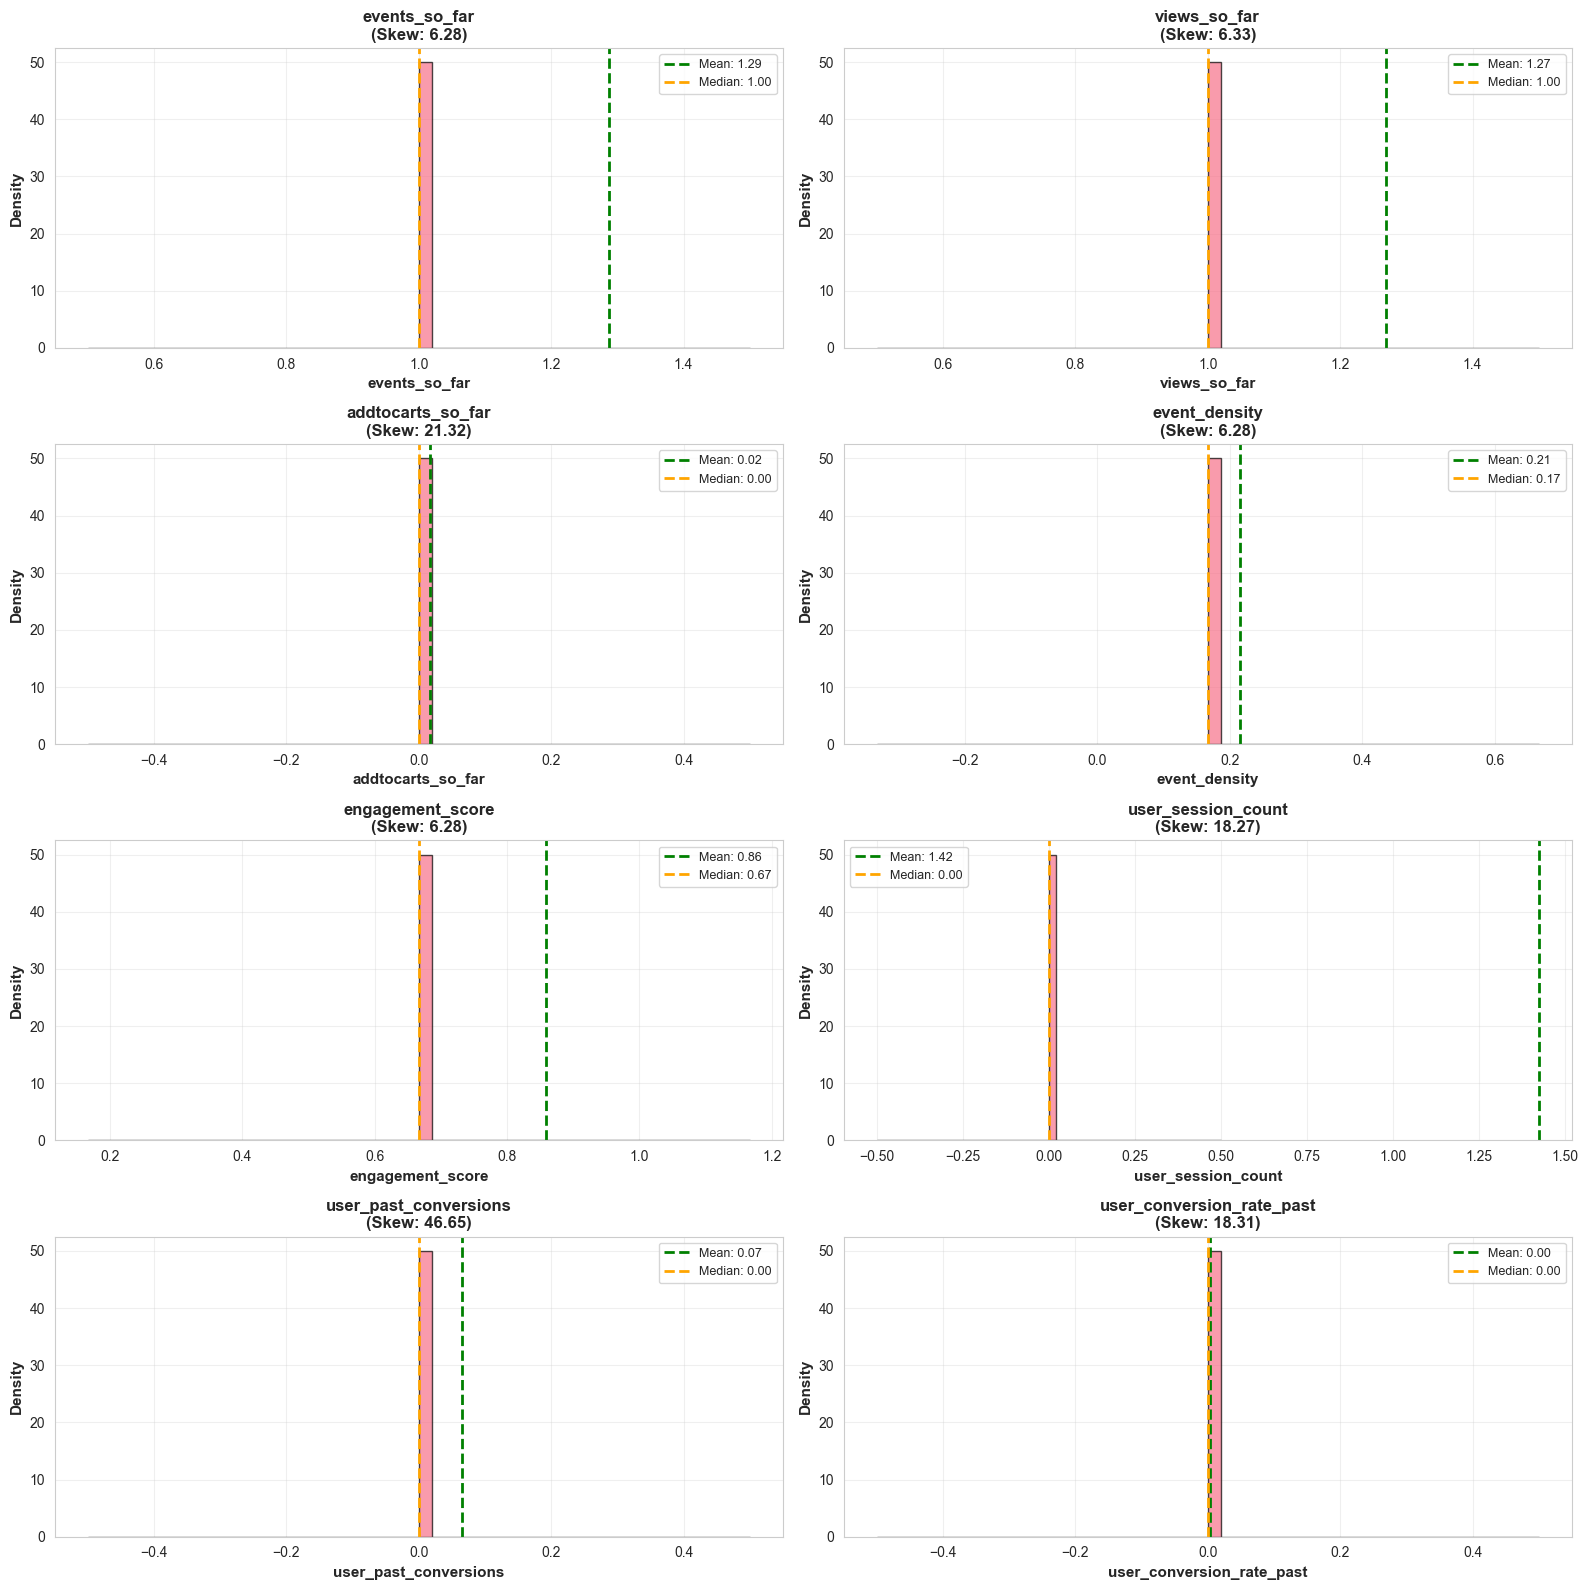

In [11]:
# ==============================
# Univariate analysis: continuous features
# ==============================

continuous_features = [
    "events_so_far",
    "views_so_far",
    "addtocarts_so_far",
    "event_density",
    "engagement_score",
    "user_session_count",
    "user_past_conversions",
    "user_conversion_rate_past",
]

# Keep only features that actually exist
available_features = [f for f in continuous_features if f in df.columns]

if not available_features:
    raise ValueError("None of the specified continuous_features exist in df")

print("UNIVARIATE ANALYSIS: Continuous Features")
print("=" * 70)
print(f"\nUsing features: {available_features}\n")

# Summary statistics
summary_stats = df[available_features].describe().T
summary_stats["skewness"] = df[available_features].skew()
summary_stats["kurtosis"] = df[available_features].kurtosis()

print("\nSummary Statistics:")
print(summary_stats.to_string())

# Visualize distributions
n_feats = len(available_features)
n_rows = int(np.ceil(n_feats / 2))
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4 * n_rows))
axes = np.array(axes).ravel()

for idx, feature in enumerate(available_features):
    ax = axes[idx]
    series = df[feature].dropna()

    # Guard against constant columns
    if series.nunique() <= 1:
        ax.text(0.5, 0.5, f"{feature}\n(constant)", ha="center", va="center")
        ax.axis("off")
        continue

    # Remove outliers for better visualization (IQR rule)
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    data_plot = series[(series >= lower) & (series <= upper)]

    # Histogram
    ax.hist(data_plot, bins=50, alpha=0.7, edgecolor="black", density=True)

    # KDE – skip if it fails or data is too degenerate
    try:
        if data_plot.nunique() > 1:
            data_plot.plot(kind="kde", ax=ax, color="red", linewidth=2)
    except Exception:
        pass

    mean_val = series.mean()
    median_val = series.median()
    ax.axvline(mean_val, color="green", linestyle="--",
               linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color="orange", linestyle="--",
               linewidth=2, label=f"Median: {median_val:.2f}")

    ax.set_title(f"{feature}\n(Skew: {series.skew():.2f})", fontweight="bold")
    ax.set_xlabel(feature, fontweight="bold")
    ax.set_ylabel("Density", fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

for j in range(len(available_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 3.2 Univariate Analysis: Categorical Features


UNIVARIATE ANALYSIS: Categorical Features


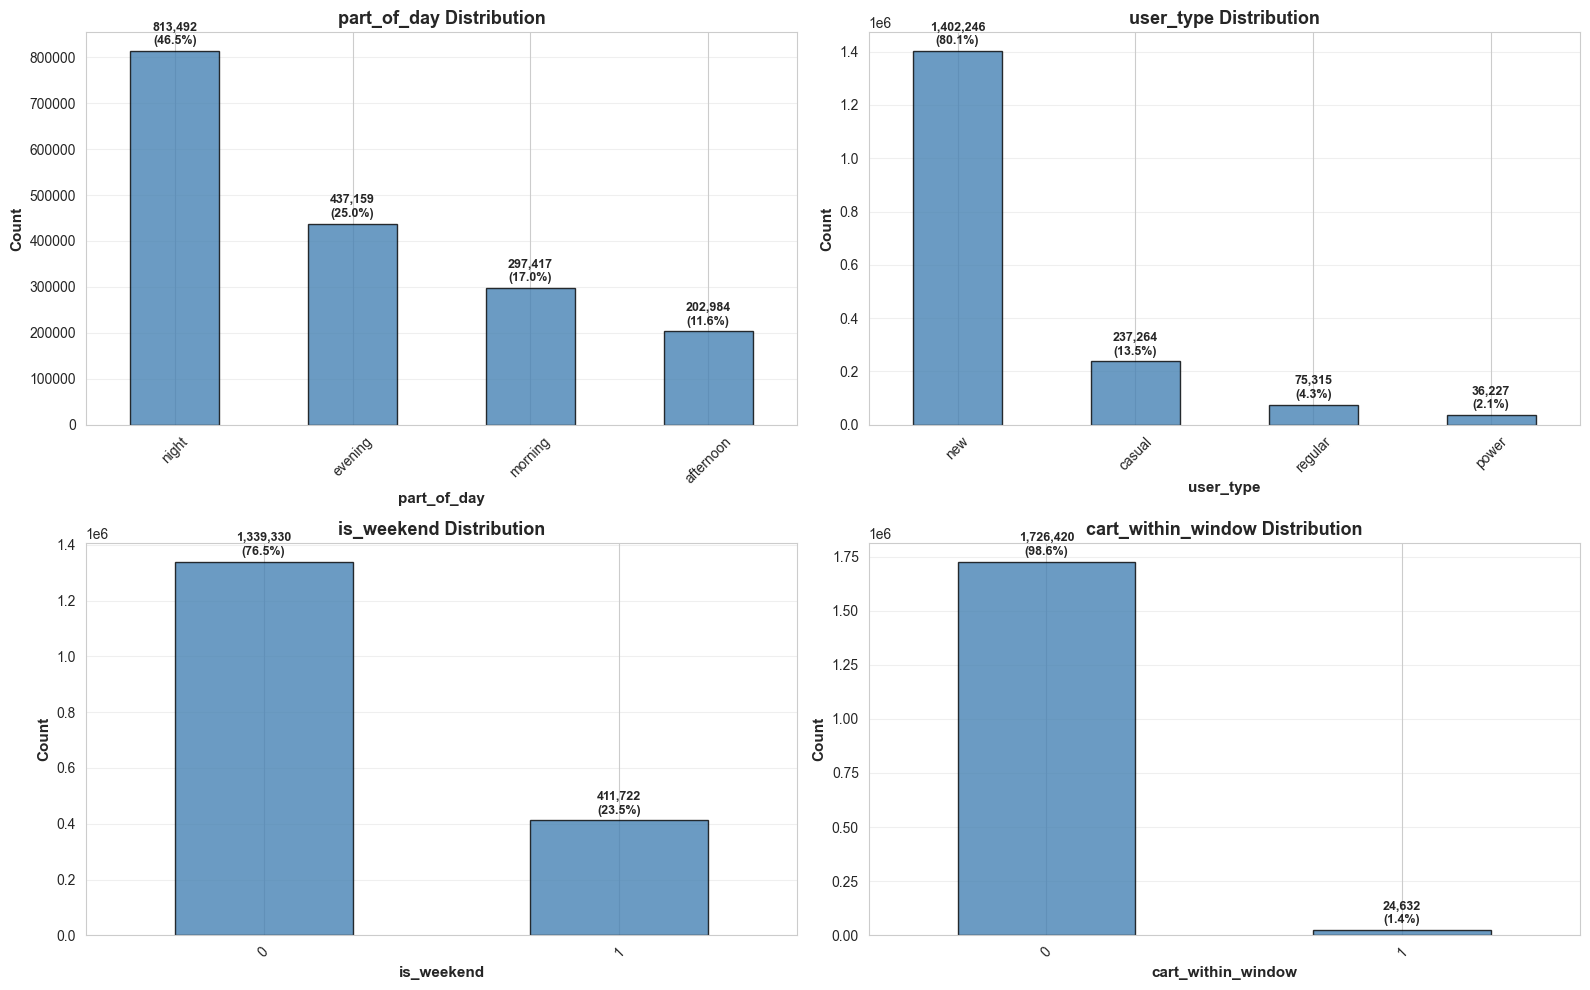

In [12]:
# Select key categorical features
categorical_features = [
    'part_of_day',
    'user_type',
    'is_weekend',
    'cart_abandoned'
]

# Replace missing legacy feature with leakage-safe alternative(s)
if 'cart_abandoned' not in df.columns:
    if 'cart_within_window' in df.columns:
        categorical_features[-1] = 'cart_within_window'
    elif 'reached_cart_prefix' in df.columns:
        categorical_features[-1] = 'reached_cart_prefix'
    else:
        categorical_features = [c for c in categorical_features if c != 'cart_abandoned']

print("\nUNIVARIATE ANALYSIS: Categorical Features")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

# Only plot features that exist
categorical_features = [f for f in categorical_features if f in df.columns]

for idx in range(4):
    ax = axes[idx]
    if idx >= len(categorical_features):
        ax.axis("off")
        continue

    feature = categorical_features[idx]
    value_counts = df[feature].value_counts(dropna=False)

    value_counts.plot(kind='bar', ax=ax, color='steelblue',
                      edgecolor='black', alpha=0.8)

    ax.set_title(f'{feature} Distribution', fontweight='bold', fontsize=13)
    ax.set_xlabel(feature, fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    for i, (cat, count) in enumerate(value_counts.items()):
        percentage = count / len(df) * 100
        ax.text(i, count + max(value_counts)*0.01,
                f'{count:,}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


### 3.3 Bivariate Analysis: Feature vs Conversion

Analyze how each feature relates to conversion.


BIVARIATE ANALYSIS: Feature vs Conversion


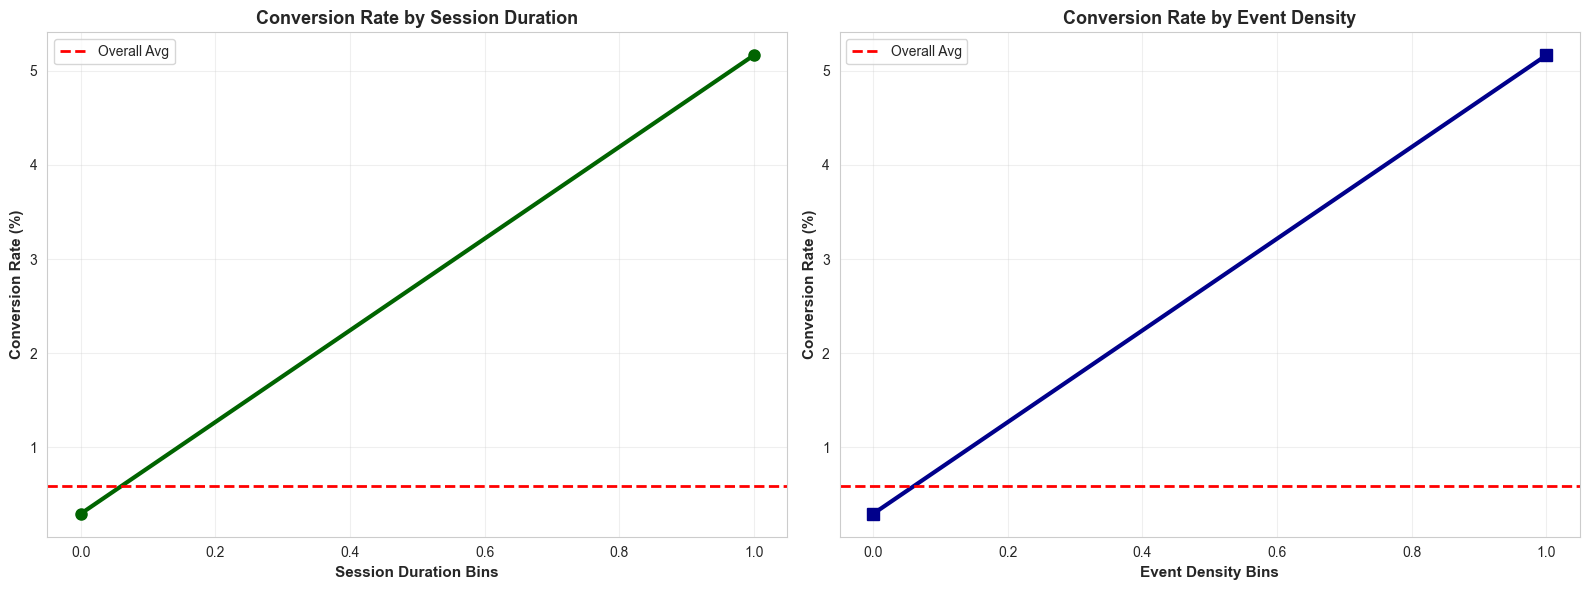

In [13]:
print("\nBIVARIATE ANALYSIS: Feature vs Conversion")
print("="*70)

# Calculate conversion rate by continuous features (binned)
def conversion_by_bins(df, feature, n_bins=10):
    """Calculate conversion rate by binned feature."""
    df_temp = df[[feature, 'target']].copy()
    df_temp['bin'] = pd.qcut(df_temp[feature], q=n_bins, duplicates='drop')

    conv_by_bin = df_temp.groupby('bin').agg({
        'target': ['count', 'sum', 'mean']
    })
    conv_by_bin.columns = ['count', 'conversions', 'conv_rate']
    return conv_by_bin

# Analyze session duration (leakage-safe replacement: events_so_far)
duration_feature = 'events_so_far' if 'events_so_far' in df.columns else 'time_since_session_start_seconds'
conv_by_duration = conversion_by_bins(df, duration_feature, n_bins=10)

# Analyze event density
conv_by_density = conversion_by_bins(df[df['event_density'] <= 10],
                                      'event_density', n_bins=10)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Session duration vs conversion
ax = axes[0]
x_vals = range(len(conv_by_duration))
ax.plot(x_vals, conv_by_duration['conv_rate'] * 100,
        marker='o', linewidth=3, markersize=8, color='darkgreen')
ax.axhline(y=df['target'].mean()*100, color='red',
           linestyle='--', linewidth=2, label='Overall Avg')
ax.set_xlabel('Session Duration Bins', fontweight='bold')
ax.set_ylabel('Conversion Rate (%)', fontweight='bold')
ax.set_title('Conversion Rate by Session Duration', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

# Event density vs conversion
ax = axes[1]
x_vals = range(len(conv_by_density))
ax.plot(x_vals, conv_by_density['conv_rate'] * 100,
        marker='s', linewidth=3, markersize=8, color='darkblue')
ax.axhline(y=df['target'].mean()*100, color='red',
           linestyle='--', linewidth=2, label='Overall Avg')
ax.set_xlabel('Event Density Bins', fontweight='bold')
ax.set_ylabel('Conversion Rate (%)', fontweight='bold')
ax.set_title('Conversion Rate by Event Density', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.4 Statistical Correlation with Target


STATISTICAL CORRELATION ANALYSIS

Point-Biserial Correlation (Feature vs Conversion):
                  feature  correlation  p_value significant
        addtocarts_so_far       0.3129   0.0000           ✅
user_conversion_rate_past       0.1769   0.0000           ✅
    user_past_conversions       0.1748   0.0000           ✅
            events_so_far       0.1407   0.0000           ✅
            event_density       0.1407   0.0000           ✅
         engagement_score       0.1407   0.0000           ✅
       user_session_count       0.0587   0.0000           ✅
             views_so_far       0.0568   0.0000           ✅


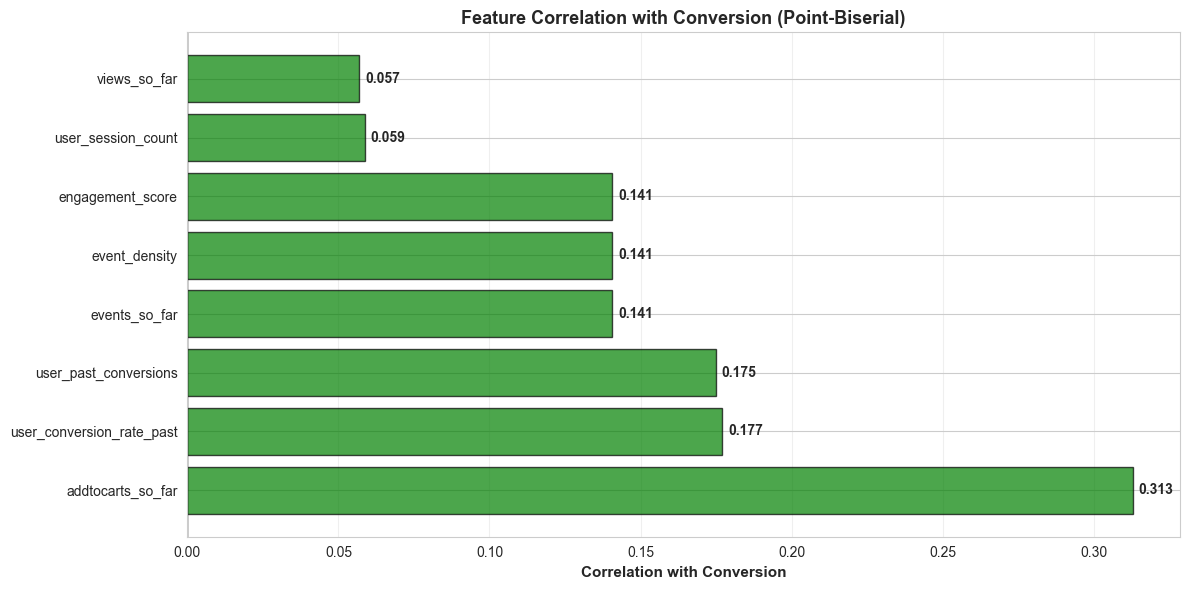

In [14]:
"""### 3.4 Statistical Correlation with Target"""

print("\nSTATISTICAL CORRELATION ANALYSIS")
print("="*70)

# Use only features that exist, and use target (single source of truth)
correlations = []
features_for_corr = [f for f in available_features if f in df.columns]

for feature in features_for_corr:
    valid_data = df[[feature, 'target']].dropna()

    if len(valid_data) > 0 and valid_data[feature].nunique() > 1:
        corr, p_value = pointbiserialr(valid_data['target'], valid_data[feature])
        correlations.append({
            'feature': feature,
            'correlation': corr,
            'p_value': p_value,
            'significant': '✅' if p_value < 0.05 else '❌'
        })

corr_df = pd.DataFrame(correlations)
if len(corr_df) == 0:
    print("\nNo valid correlations computed (insufficient variation).")
else:
    corr_df = corr_df.sort_values('correlation', ascending=False, key=abs)

    print("\nPoint-Biserial Correlation (Feature vs Conversion):")
    print(corr_df.to_string(index=False))

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['green' if c > 0 else 'red' for c in corr_df['correlation']]
    bars = ax.barh(corr_df['feature'], corr_df['correlation'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Correlation with Conversion', fontweight='bold')
    ax.set_title('Feature Correlation with Conversion (Point-Biserial)', fontweight='bold', fontsize=13)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')

    for bar, val in zip(bars, corr_df['correlation']):
        width = bar.get_width()
        ax.text(width + 0.002 if width > 0 else width - 0.002, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width > 0 else 'right', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()


---

Due to length constraints, this notebook continues with:
- Multivariate analysis (correlations, VIF)
- Segmentation analysis  
- Feature importance (Random Forest)
- Feature selection
- Save final dataset

**This is a comprehensive starting point. You can expand each section based on your findings.**

### 3.5 Save ML-Ready Dataset

In [ ]:
"""### 3.5 Save ML-Ready Dataset
"""

# Build strict feature set (whitelist)
FEATURES = temporal_features + behavioral_features + funnel_features + user_features
FEATURES = [f for f in FEATURES if f in df.columns]

KEEP_COLS = ["session_id", "visitorid", "session_start", "target"] + FEATURES
KEEP_COLS = [c for c in KEEP_COLS if c in df.columns]

df_safe = df[KEEP_COLS].copy()

# Convert datetimes to strings (PyArrow safe)
dt_cols = df_safe.select_dtypes(include=["datetime64[ns]"]).columns
for c in dt_cols:
    df_safe[c] = df_safe[c].astype(str)

output_path = data_extracts / 'ml_features.parquet'
df_safe.to_parquet(output_path, index=False)

print("="*70)
print(" ML-READY DATASET SAVED (Feature Whitelist Enforced)")
print("="*70)
print(f"File: {output_path}")
print(f"Rows: {len(df_safe):,}")
print(f"Columns: {len(df_safe.columns)}")
print(f"Size: {output_path.stat().st_size / 1024**2:.2f} MB")
print(f"Target: target = {df_safe['target'].mean()*100:.2f}%")
print(f"Features saved: {len(FEATURES)}")
print("\n Ready for modeling in Notebook 04! (Use df_safe)")


✅ ML-READY DATASET SAVED (Feature Whitelist Enforced)
File: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/extracts/ml_features.parquet
Rows: 1,751,052
Columns: 25
Size: 37.52 MB
Target: target = 0.59%
Features saved: 21

🚀 Ready for modeling in Notebook 04! (Use df_safe)
